In [1]:
import torch
import rdkit 
from torch_geometric.datasets import MoleculeNet


### ESOL Dataset

In [2]:
# load ESOL dataset: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.MoleculeNet.html
data = MoleculeNet(root='.',name='ESOL')
data

ESOL(1128)

In [3]:
# print first 5 examples
for i in range(5):
    print(data[i])

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Data(x=[15, 9], edge_index=[2, 32], edge_attr=[32, 3], smiles='Cc1occc1C(=O)Nc2ccccc2', y=[1, 1])
Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles='CC(C)=CCCC(C)=CC(=O)', y=[1, 1])
Data(x=[22, 9], edge_index=[2, 52], edge_attr=[52, 3], smiles='c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', y=[1, 1])
Data(x=[5, 9], edge_index=[2, 10], edge_attr=[10, 3], smiles='c1ccsc1', y=[1, 1])


In [4]:
# nodes of the first graph: [num_nodes,node_features]
data[0].x[:10]

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1]])

In [5]:
# edges of the first graph (this is shwoing only the connected nodes), shape: [2, num_nodes]
data[0].edge_index.T[:10]

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5]])

In [6]:
# target value 
data[0].y

tensor([[-0.7700]])

### Convert SMILES to RDKit molecules 

In [7]:
# get the smiles reperesentation of the first molecule (or the first graph)
data[0]['smiles']

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

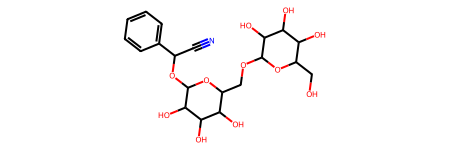

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
mol = Chem.MolFromSmiles(data[0]['smiles'])
mol

In [9]:
# we can get molecule details from RDKit (in ESOL dataset they are provided in the datset)
print(f'Number of bonds: {mol.GetNumBonds()}')
print(f'Number of atoms: {mol.GetNumAtoms()}')

Number of bonds: 34
Number of atoms: 32


### Implementing Graph Neural Network (GNN)

* Building GNN works same way as building CNN (with some additional functionality)

* In this example we apply 3 convolutional layers (i.e. we want to learn the information about 3 neighbor hops). 

In [10]:
import torch 
from torch.nn import Linear 
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool
embedding_size = 64

In [11]:
torch.manual_seed(42)

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # GCN layers 
        self.init_cov = GCNConv(data.num_features,embedding_size)               # (9,64)
        self.conv1 = GCNConv(embedding_size,embedding_size)                     # (64,64)
        self.conv2 = GCNConv(embedding_size,embedding_size)                     # (64,64)
        self.conv3 = GCNConv(embedding_size,embedding_size)                     # (64,64)
        
        # output linear layer 
        self.out = Linear(embedding_size*2,1)                                   # (128,1)
        
    def forward(self,x,edge_index,batch_index):
        # frst conv layer 
        hidden = self.init_cov(x,edge_index)                                    # (Nodes,9) @ (9,64)   -> (Nodes,64)
        hidden = F.tanh(hidden)
        # other conv layers 
        hidden = self.conv1(hidden,edge_index)                                  # (Nodes,64) @ (64,64) -> (Nodes,64)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden,edge_index)                                  # (nodes,64) @ (64,64) -> (Nodes,64)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden,edge_index)                                  # (Nodes,64) @ (64,64) -> (Nodes,64)
        hidden = F.tanh(hidden)
        # global pooling (stack different aggregations):                        # concat[(1,64), (1,64)] -> (2,64)
        hidden = torch.cat([global_mean_pool(hidden,batch_index),
                            global_max_pool(hidden,batch_index)], dim = 1) 
        
        # final linear layer
        out = self.out(hidden)                                                  # 1
        return out, hidden 

model = GCN()
print(model)
print("Total model parameters:", sum(p.numel() for p in model.parameters()))

GCN(
  (init_cov): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Total model parameters: 13249


### Model Training 

In [12]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

# loss function and optimizer 
loss_fn = torch.nn.MSELoss() # RMSE loss 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

# use GPU if available 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# create train and validation data loaders 
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
n1 = int(0.8*data_size)
train_data_loader = DataLoader(data[:n1], batch_size=NUM_GRAPHS_PER_BATCH,shuffle=True)
val_data_loader = DataLoader(data[n1:],batch_size=NUM_GRAPHS_PER_BATCH,shuffle=True)

In [13]:
# training function 
def training():
    for batch in train_data_loader:
        batch.to(device)                                                   # send data to GPU 
        optimizer.zero_grad()                                              # clear the grad (before next iter)
        pred,embd = model(batch.x.float(),batch.edge_index,batch.batch)    # get the prediction 
        loss = loss_fn(pred,batch.y)                                       # get the loss 
        loss.backward()                                                    # find the gradient of loss wrt weights
        optimizer.step()                                                   # update the weights 
    return loss, embd

In [14]:
# do training for 1000 epochs 
losses = []
for epoch in range(1000):
    loss, h = training()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch:{epoch} | Train Loss:{loss:.4f}')

Epoch:0 | Train Loss:24.3438
Epoch:100 | Train Loss:1.8671
Epoch:200 | Train Loss:2.3988
Epoch:300 | Train Loss:0.2217
Epoch:400 | Train Loss:1.1435
Epoch:500 | Train Loss:0.7294
Epoch:600 | Train Loss:0.0845
Epoch:700 | Train Loss:1.3993
Epoch:800 | Train Loss:0.6092
Epoch:900 | Train Loss:0.8524


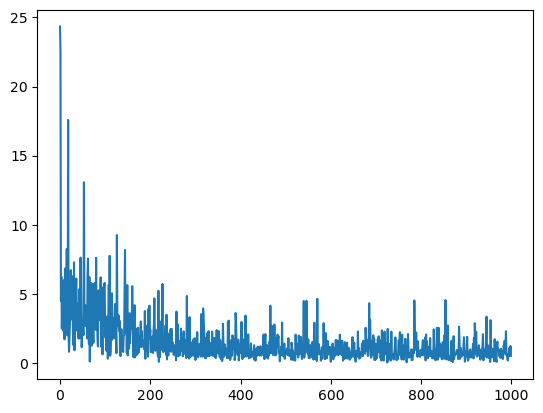

In [15]:
# plot the train loss 
import matplotlib.pyplot as plt 
import numpy as np

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
plt.plot(np.arange(len(losses)), losses_float)

In [16]:
# let's make predictions (on one batch from the validation data set)
val_results = [[],[]]
test_batch = next(iter(val_data_loader))
with torch.no_grad():
    test_batch.to(device)
    pred,embd = model(test_batch.x.float(),test_batch.edge_index,test_batch.batch)
    val_results[0].append(test_batch.y.tolist())
    val_results[1].append(pred.tolist())

In [17]:
# actual and predicted values (first 10) 
val_np = np.array(val_results).reshape(2,64)
val_np.T[:10]

array([[-4.57000017, -3.76027203],
       [-2.06999993, -3.76574636],
       [-8.39999962, -5.73138237],
       [-0.972     , -0.07234637],
       [-3.38000011, -3.04745531],
       [-0.95999998, -1.48726916],
       [-2.98200011, -2.00943065],
       [ 0.94      , -1.00357187],
       [-4.17299986, -4.41378212],
       [-2.57999992, -2.82529163]])

Text(0.5, 0, 'Actual')

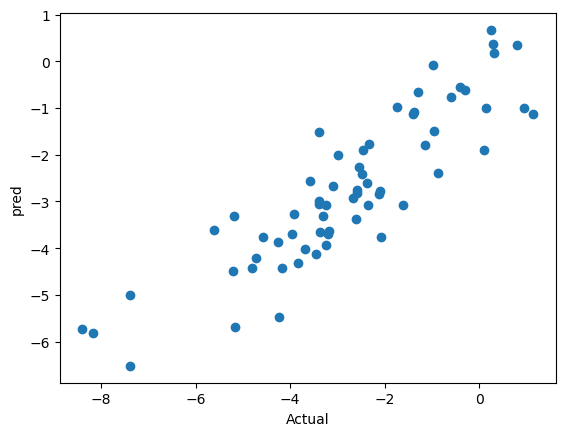

In [18]:
# plot model prediction against actual values
plt.scatter(val_np[0],val_np[1])
plt.ylabel('pred')
plt.xlabel('Actual')

### Future improvements

* Dropout
* Batch Normalization
* Other types of pooling 
* Add more layers
* Test the hidden layer sizes, different test matrices and hyper parameter tuning 